![](header.jpg)

# Image Processing: Filtering

Kevin J. Walchko

create 16 Aug 2017

---

Now that we know how to read in images and manipulate them a little, let's do some image processing. Image processing is processing of images using mathematical operations by using any form of signal processing for which the input is an image, a series of images or a video; the output of image processing may be either an image or a set of characteristics or parameters related to the image. Most image-processing techniques involve isolating the individual color planes of an image and treating them as two-dimensional signals and applying standard signal-processing techniques to them. Images are also processed as three-dimensional signals with the third dimension being time or the z-axis.

## References

- [Wikipedia Image Processing](https://en.wikipedia.org/wiki/Image_processing)
- [Wikipedia Convolution](https://en.wikipedia.org/wiki/Convolution)
- [Official OpenCV python tutorials](http://docs.opencv.org/3.1.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
- [Official OpenCV Harris corner detector tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html)
- [Official OpenCV homography tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html)
- [Feature detection survey](http://campar.in.tum.de/twiki/pub/Chair/TeachingWs09MATDCV/FT_survey_interestpoints08.pdf)
- [Morphological Operations](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html#morphological-ops)
- [OpenCV thresholding](https://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html)
- [OpenCV Laplace Operator](https://docs.opencv.org/3.4.0/d5/db5/tutorial_laplace_operator.html)
- [OpenCV Sobel Operator](https://docs.opencv.org/3.4.0/d2/d2c/tutorial_sobel_derivatives.html)
- [OpenCV Canny Edge Detector](https://docs.opencv.org/3.4.0/da/d5c/tutorial_canny_detector.html)

## Setup

In [4]:
import cv2         # opencv itself
import numpy as np # matrix manipulations
import random

from matplotlib import pyplot as plt           
import pylab                                   
pylab.rcParams['figure.figsize'] = (10.0, 10.0) 

# Basic Image Operations

When I was young, I used to play Dungeons & Dragons (D&D). A lot of Sci-Fi/Fantasy books, movies, games, pop culture, etc have been influenced by D&D. Let's grab a cool image to play with.

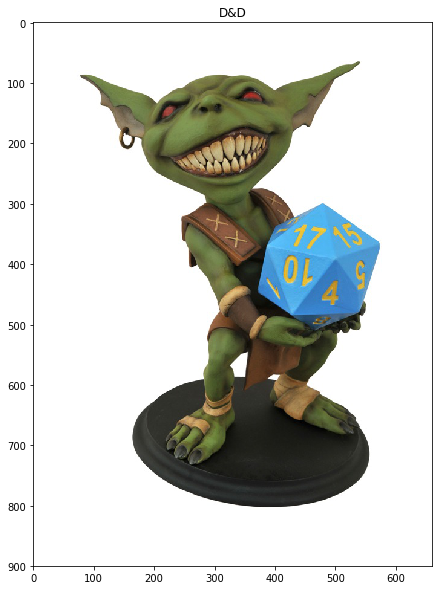

In [5]:
# Let's grab a goblin with a D20 (20 sided dice)
input_image=cv2.imread('dnd.jpg')

# remember, we have to correct the image and display it as RGB
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

# plot the image
plt.imshow(input_image)
plt.title('D&D');

## Noise reduction

Noise reduction can take many forms. The first involves blurring/smoothing an image using a  kernel. The width of the kernel determines the amount of smoothing, in other words, how many pixels are in our window. Image filtering is achieved by **convolving** the image with a filter kernel. 

![](convolution.jpg)
![](convolution2.jpg)

This is useful for removing noise. These filters remove high frequency content (eg: noise, edges) from an image so edges are blurred a little bit in this operation. (Well, there are blurring techniques which doesn’t blur the edges too). OpenCV provides mainly four types of blurring techniques.

1.  **Averaging:** This is done by convolving the image with a normalized box filter. It simply takes the average of all the pixels under the kernel area and replaces the central element. This is done by the function `cv2.blur()` or `cv2.boxFilter()`. Check the docs for more details about the kernel. We should specify the width and height of the kernel. A 3x3 normalized box filter would look like below:

  $$
  kernel = \frac{1}{9}
  \begin{bmatrix}
      1&1&1\\
      1&1&1\\
      1&1&1
  \end{bmatrix}
  $$ 

2. **Gaussian Blurring:** In this, instead of a box filter, a gaussian kernel is used. It is done with the function, `cv2.GaussianBlur()`. We should specify the width and height of the kernel which should be positive and odd. We also should specify the standard deviation in the X and Y directions, $\sigma_X$ and $\sigma_Y$ respectively. If only $\sigma_X$ is specified, $\sigma_Y$ is set the same as $\sigma_X$. If both are given as zeros, they are calculated from kernel size. Gaussian blurring is highly effective in removing **gaussian noise** from the image. If you want, you can create a Gaussian kernel with the function, `cv2.getGaussianKernel()`.

  $$
  kernel = \frac{1}{10}
  \begin{bmatrix}
      1&1&1\\
      1&2&1\\
      1&1&1
  \end{bmatrix}
  $$ 

3. **Median Blurring:** Here, the function `cv2.medianBlur()` takes the median of all the pixels under the kernel area and the central element is replaced with this median value. This is highly effective against **salt-and-pepper noise** in the images. The above filters all set the central element as a newly calculated value which may be a pixel value in the image or a new value. But in median blurring, central element is always replaced by some pixel value in the image. It reduces the noise effectively. The kernel size should be a positive odd integer.

4. **Bilateral Filtering:** `cv2.bilateralFilter()` is highly effective in noise removal while keeping edges sharp. But the operation is slower compared to other filters. We already seen how the gaussian filter takes a neighbourhood around the center pixel and finds the gaussian weighted average. This gaussian filter is a function of space alone, that is, only nearby pixels are used in filtering. It doesn’t consider whether a pixel is an edge pixel (large differences between pixels) or not (all pixels have a similar value). Therefore it blurs the edges, which we don’t want to do in some applications.

  Bilateral filters combine the Gaussian function of space with a function that looks at pixel intensity. The Gaussian function of space makes only uses pixel within a window for blurring while the gaussian function of intensity difference makes sure only those pixels with similar intensity to central pixel are considered for blurring. This has the effect of preserving edges in an image, since pixels at edges will have large intensity variation.

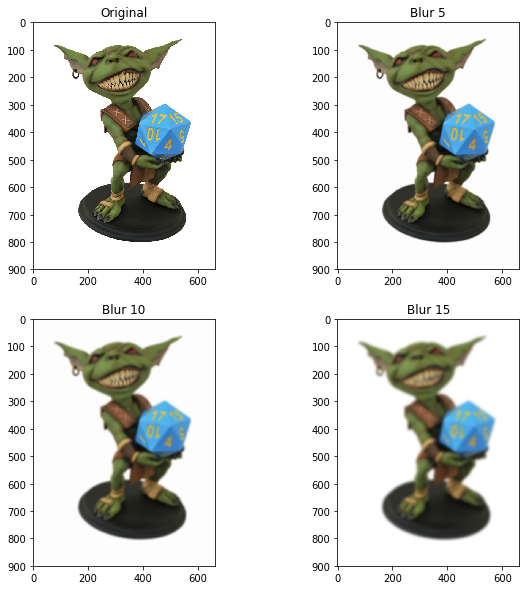

In [6]:
# Gaussian blurring
plt.subplot(2,2,1)
plt.imshow(input_image)
plt.title('Original');

for i in range(1, 4):
    plt.subplot(2,2,i+1)
    d = i*5
    img_blur3 = cv2.GaussianBlur(input_image, (2*d+1, 2*d+1), -1)
    plt.imshow(img_blur3)
    plt.title('Blur {}'.format(d))

# Salt and Pepper Noise

[Salt and pepa](https://en.wikipedia.org/wiki/Salt-N-Pepa) is a good model of a camera which has dead (image value is 0) or hot (image value is max, say 255) pixels in it. Generally manufacturers weed out sensors that have high defects, but there are always some that are bad. Cameras that are in use for a long time develop defects ... say imagers on satellites. You cannot replace those easily, so you have to deal with dead pixels.

[array([752, 688, 565, ..., 867, 106, 124]), array([173, 158, 195, ..., 414, 545, 115])]


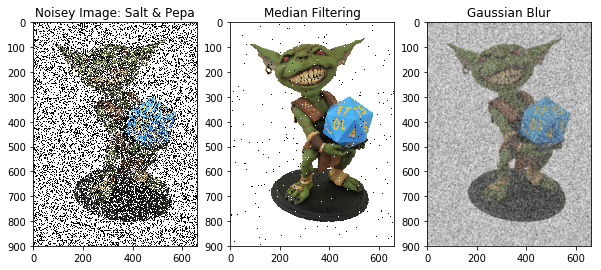

In [7]:
# this isn't really a good way to do salt n pepper noise
# but it makes the point. Also remember, a camera has
# a bayer pattern, so hot/dead pixels won't impact an
# image like I am showing here. I am almost assuming
# there is a red, blue, green image plane capturing the 
# image ... not a bayer patterned sensor
def add_salt_and_pepper(image, s_vs_p):
    row,col,ch = image.shape
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
    print(coords)
    for a,b in zip(*coords):
        out[a,b,:] = np.random.choice([0,255])
    return out

plt.subplot(1,3,1)
nimg = add_salt_and_pepper(input_image, .25)
plt.imshow(nimg);
plt.title('Noisey Image: Salt & Pepa')

plt.subplot(1,3,2)
med = cv2.medianBlur(nimg,5)
plt.imshow(med)
plt.title('Median Filtering');

plt.subplot(1,3,3)
blur = cv2.GaussianBlur(nimg, (11, 11), -1)
plt.imshow(blur)
plt.title('Gaussian Blur');

# Custom Filter Kernels

You can create a custom linear filter kernel and apply it to an image using `filter2D(img_src, ddepth, kernel)`. The `ddepth` is the desired depth of the destination image.

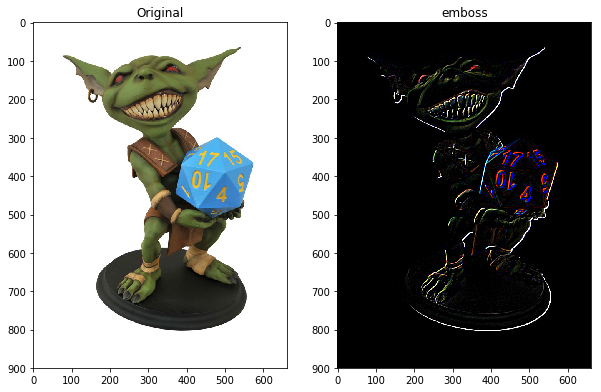

In [8]:
img = input_image.copy()

# go ahead and change the kernel to another key in the kernels hash
k = 'emboss'
kernels = {
    'emboss': np.array([[-2,-1,0],[-1,0,1],[0,1,2]]),
    'outline': np.array([[-1,-1,-1], [-1,8,-1],[-1,-1,-1]]),
    'sharpen': np.array([[0,-1,0], [-1,5,-1],[0,-1,0]]),
    'identity': np.array([[0,0,0], [0,1,0],[0,0,0]])
}

dst = cv2.filter2D(img,-1,kernels[k])

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(dst)
plt.title(k);

# Edges

For a lot of what we think of as "modern" computer vision techniques, edge detection functions as a building block. Much edge detection actually works by **convolution**, and indeed **convolutional neural networks** are absolutely the flavor of the month in some parts of computer vision. 

## Sobel

Sobel's edge detector was one of the first truly successful edge detection (enhancement) technique and that involves convolution at its core. If you look at an edge (1D here), there is a discontinuity in the image do to shadow, edge of a building against sky, etc. 

![](sobel_edge.jpg)

Now, if you take the derivative (think difference between pixels), you will get a local maximum result between pixels on one side of the edge and pixels on the other side of the edge.

![](sobel_1_der.jpg)

The basic process is:

1. Smooth an image to reduce noise, which can affect edge detection, but we have talked about that already
2. Convolve the image with something like the Sobel vertical ($G_y$) and horizontal edge ($G_x$) detector which gives you the first derivative of the image in those directions. Then you can find the gradient and direction for each pixel as:

  $$
  \nabla Edge(G)=\sqrt{G_x^2 + G_y^2} \\
  Angle = \arctan(\frac{G_y}{G_x})
  $$

3. Non-maximum Suppression, which basically checks if each pixel is local maximum in its neighborhood in the direction of gradient. 
  
  ![](nms.jpg)

  Point A is on the edge ( in vertical direction). Gradient direction is normal to the edge. Point B and C are in gradient directions. So point A is checked with point B and C to see if it forms a local maximum. If so, it is kept, otherwise, it is suppressed ( put to zero).

Some kernels used for edge detection are:

  $$
  Sobel_x =
  \begin{bmatrix}
      -1&0&1\\
      -2&0&2\\
      -1&0&1
  \end{bmatrix}\\
  Sobel_y =
  \begin{bmatrix}
      1&2&1\\
      0&0&0\\
      -1&-2&-1
  \end{bmatrix}
  $$ 

Hopefully, you can see how the Sobel kernels detect edges in the x-dir or y-dir. The Laplace kernel actually detects edges in both directions. 

Let's do an example:

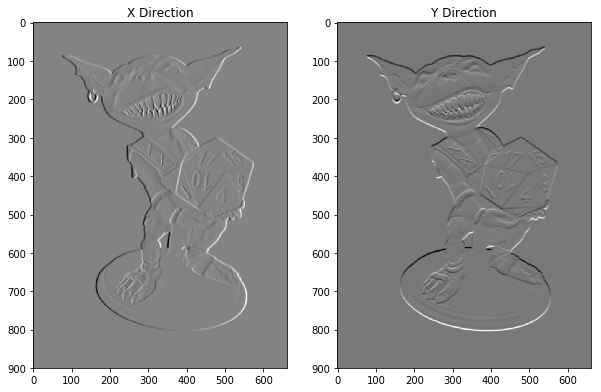

In [9]:
# edge detection is done in grayscale, so make sure you convert
# correctly like: RGB2GRAY or BGR2GRAY
sobelimage=cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)

sobelx = cv2.Sobel(sobelimage,cv2.CV_64F,1,0,ksize=9)
sobely = cv2.Sobel(sobelimage,cv2.CV_64F,0,1,ksize=9)

plt.subplot(1,2,1)
plt.imshow(sobelx,cmap = 'gray') 
plt.title('X Direction')

plt.subplot(1,2,2)
plt.imshow(sobely,cmap = 'gray');
plt.title('Y Direction');

For Sobel, see how the higher values (blacks and whites) for the x-direction are oriented on the left/right of the image as the kernel moves over the image? Also, the y-direction, is similar with the values in the up/down direction. You should be able to look at the kernel for each and see how they will react with an image.

## Laplacian

It turns out that if you take the second derivative, then edges have values of 0.

![](laplace.jpg)

$$
  Laplace(f) = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2} \\
  Laplacian =
  \begin{bmatrix}
      0&-1&0\\
      -1&4&-1\\
      0&-1&0
  \end{bmatrix}
$$

The other nice thing about this, is, the laplace operator does both x and y edges in one concolution!

```python
dst = cv.Laplacian(src_gray, ddepth, kernel_size)
```

## Canny Edge Detection

Canny edge detection is another popular method and has the following steps:

1. Filter out noise with a gaussian filter
1. Find the intensit gradient with is similar to Sobel
1. *Non-maximum suppression* which removes pixels that are not considered to be part of an edge (remember, edges are local maximums in the 1st derivative)
1. *Hysteresis* which involves 2 thresholding values. Suggested values are 2:1 and 3:1
    1. Pixel values > higher threshold value are kept as edges
    1. Pixel values < lower threshold value are thrown away
    1. Higher threshold > pixel value > lower threshold: these pixel values are kept *only if* they are connected to an edge

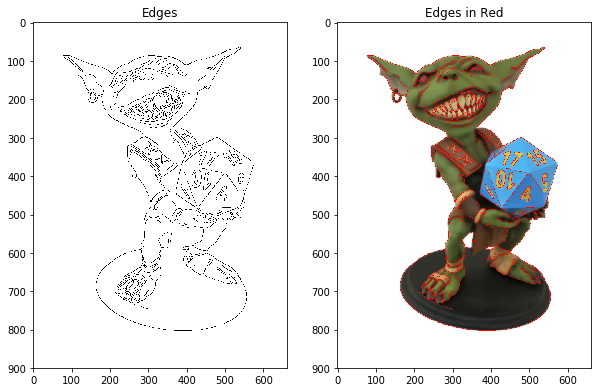

In [10]:
th1=30
th2=60 # Canny recommends threshold 2 is 3 times threshold 1 - you could try experimenting with this...
d=3    # gaussian blur or smoothing is common to eliminate pixel noise in a real camera image

# make a copy so we don't destroy the original
edgeresult=input_image.copy()

# smooth out little pixel noises
edgeresult = cv2.GaussianBlur(edgeresult, (2*d+1, 2*d+1), -1)

# find edges
gray = cv2.cvtColor(edgeresult, cv2.COLOR_BGR2GRAY)
edge = cv2.Canny(gray, th1, th2)

# this takes pixels in edgeresult where edge non-zero colors them
edgeresult[edge != 0] = (255, 0, 0)

plt.subplot(1,2,1)
# invert colors so black on white ... I think it is easier to see it this way
plt.imshow(cv2.bitwise_not(edge), cmap='gray')
plt.title('Edges');

plt.subplot(1,2,2)
plt.imshow(edgeresult)
plt.title('Edges in Red');

Many advanced algorithms, like face detection, use these ideas (smoothing, edge detection, color space changes, etc) to do higher level operations.

# Morphological Operators

Often in computer vision, we are trying to detect objects and have advanced algorithms that produce grayscale (think True (255) and False (0)) outputs marking if the algorithm found what it is looking for. However, because of noise, lighting, camera angle, and other reasons you need to clean up your images.

## Erosion

The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of the foreground object (Always try to keep foreground in white). So what does it do? The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero).

So what happends is, all the pixels near the boundary will be discarded depending upon the size of kernel. So the thickness or size of the foreground object decreases, or simply the white region decreases in the image. It is useful for removing small white noises, detaching two connected objects, etc.

## Dilation

Dilation is the opposite of erosion. Here, a pixel element is ‘1’ if at least one pixel under the kernel is ‘1’. So it increases the white region in the image orthe size of the foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation. This is often the case because erosion removes white noises, but it also shrinks our object. So we then dilate it to get its boundry back again. Since the noise is gone from the image, it won’t come back when we dilate, but our object area increases. It is also useful in joining broken parts of an object.

## Opening

Opening is just another name of erosion followed by dilation. It is useful in removing noise, as we explained above. Here we use the function, `cv2.morphologyEx()`

## Closing

Closing is the reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

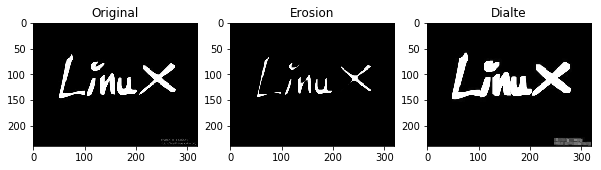

In [11]:
img = cv2.imread('linux.jpg',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
dilation = cv2.dilate(img,kernel,iterations = 1)

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(1,3,2)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')

plt.subplot(1,3,3)
plt.imshow(dilation, cmap='gray')
plt.title('Dialte');

## Opening

Here, white noise is added to the image. Using opening removes the white noise, but preserves the original image. Remember: opening = erosion -> dialate

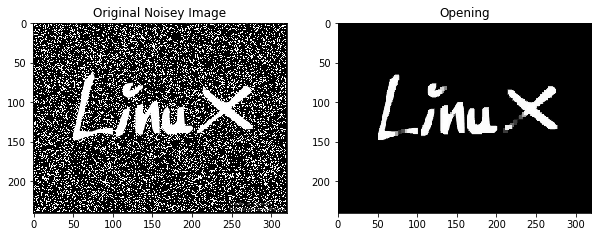

In [12]:
def grayscale_noise(image, s_vs_p, value):
    row,col = image.shape
    out = np.copy(image)
    
    num_salt = np.ceil(image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    for a,b in zip(*coords):
        out[a,b] = value
    return out

nj = grayscale_noise(img, .25, 255)
opening = cv2.morphologyEx(nj, cv2.MORPH_OPEN, kernel)

plt.subplot(1,2,1)
plt.imshow(nj, cmap='gray')
plt.title('Original Noisey Image')

plt.subplot(1,2,2)
plt.imshow(opening, cmap='gray')
plt.title('Opening');

## Closing

Now, imagine we ran an algorithm to detect letters in an image and for some reason, parts of the word linux were not detected. Using closing closes up the black holes and makes linux look better. Remember: closing = dialate -> erosion

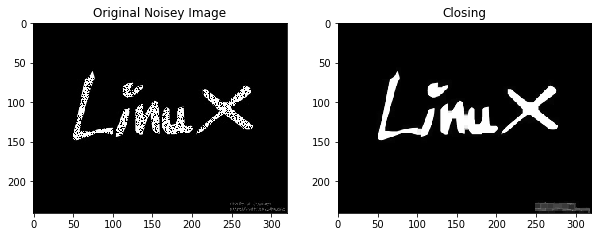

In [13]:
nj = grayscale_noise(img, .25, 0)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

plt.subplot(1,2,1)
plt.imshow(nj, cmap='gray')
plt.title('Original Noisey Image')

plt.subplot(1,2,2)
plt.imshow(closing, cmap='gray')
plt.title('Closing');

# Thresholding

There are numerous applications where we want to have a black and white (true and false in some cases) image. Thresholding allows us to do this. 

All thresholding algorithms take a source image (src) and a threshold value (thresh) as input and produce an output image (dst) by comparing the pixel value at source pixel ( x , y ) to the threshold. If src ( x , y ) > thresh , then dst ( x , y ) is assigned a some value. Otherwise dst ( x , y ) is assigned some other value.

In its simplest form, thresholding is called Binary Thresholding. In addition to the source image (src) and threshold value (thresh), it takes another input parameter called maximum value ( maxValue ). At each pixel location (x,y) it basically does the following: 

```python
# Binary Threshold
if src(x,y) > thresh
  dst(x,y) = maxValue
else
  dst(x,y) = 0
```

`cv2.threshold(image, threshold, maxValue, type)` where

- image: is the source image
- threshold: is the threshold value as defined above
- maxValue: is what the pixel is set to if the threshold is exceeded
- type: there are several types of thresholding opertions available

OpenCV offers up a few different types:

- cv2.THRESH_BINARY: pixel > threshold, set it to maxValue
- cv2.THRESH_BINARY_INV: same as above, but the output is inverted
- cv2.THRESH_TRUNC: pixel > threshold, set to threshold, but if it isn't leave it alone
- cv2.THRESH_TOZERO: pixel < threshold, set to 0, but if it is above, leave it alone
- cv2.THRESH_TOZERO_INV: same as above, but inverted

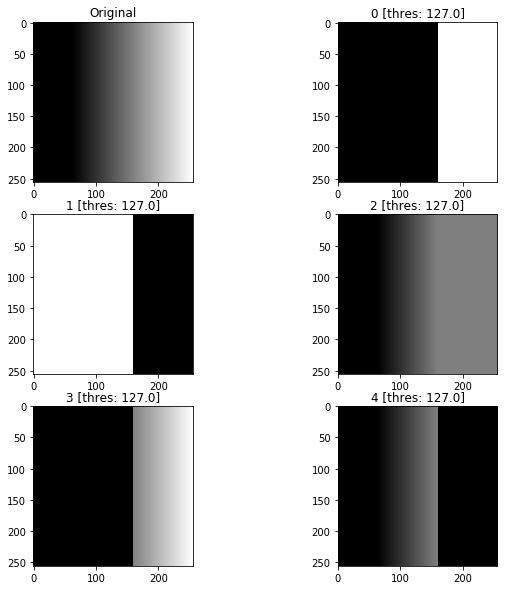

In [14]:
thresh_types = [cv2.THRESH_BINARY,
                cv2.THRESH_BINARY_INV,
                cv2.THRESH_TRUNC,
                cv2.THRESH_TOZERO,
                cv2.THRESH_TOZERO_INV]

img=cv2.imread('gradient.png')

plt.subplot(3,2,1)
plt.imshow(img)
plt.title('Original')

for i, thres in enumerate(thresh_types):
    th, dst = cv2.threshold(img, 127, 255, thres)
    plt.subplot(3,2,i+2)
    plt.imshow(dst)
    plt.title('{} [thres: {}]'.format(thres, th))

Text(0.5,1,u'Original')

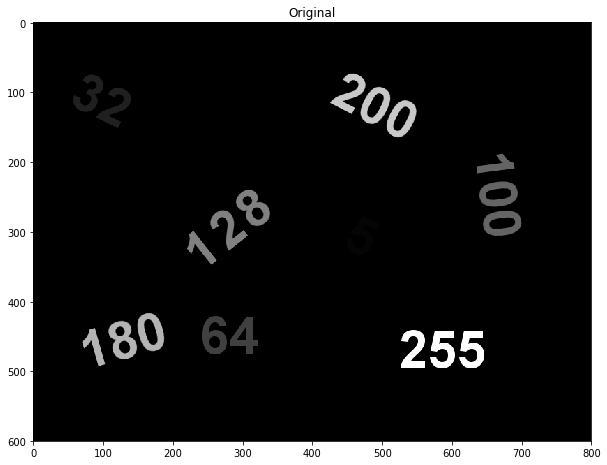

In [15]:
img=cv2.imread('numbers.png')
plt.imshow(img)
plt.title('Original')

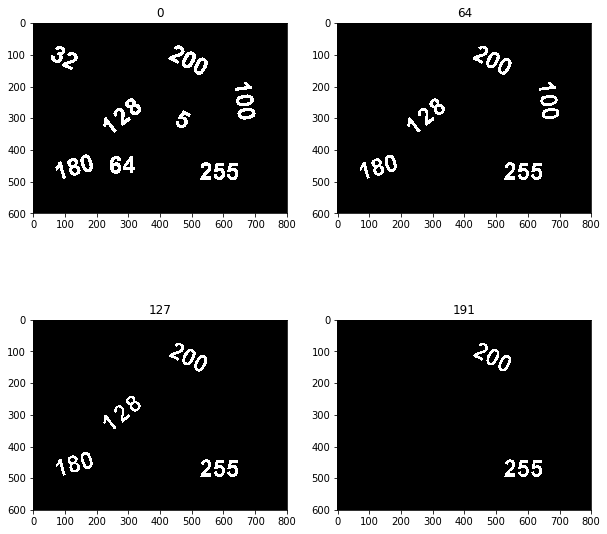

In [18]:
# let's see what playing with the threshold level does
for i, level in enumerate([0, 64, 127, 191]):
    th, dst = cv2.threshold(img, level, 255, cv2.THRESH_BINARY)
    plt.subplot(2,2,i+1)
    plt.imshow(dst)
    plt.title(str(level))

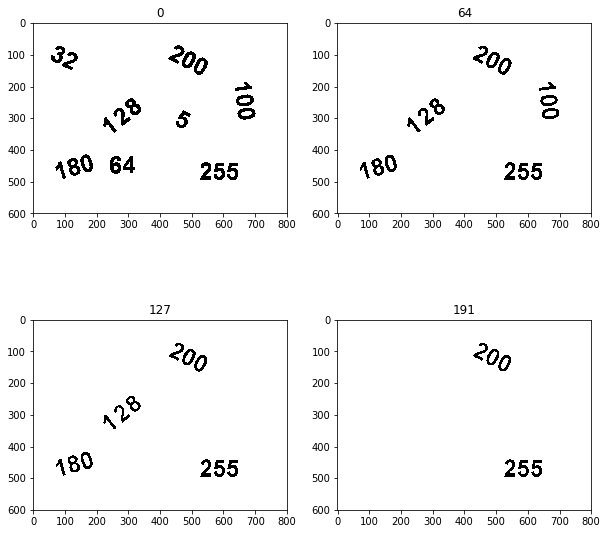

In [19]:
# let's change the type of thresholding and invert the result
for i, level in enumerate([0, 64, 127, 191]):
    th, dst = cv2.threshold(img, level, 255, cv2.THRESH_BINARY_INV)
    plt.subplot(2,2,i+1)
    plt.imshow(dst)
    plt.title(str(level))